In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
from PIL import Image
import time

from QuantumUtils import QuantumGates as QG
from QuantumUtils import utils as ut
from QuantumUtils import Circuits as cu

import pennylane as qml

In [2]:
# device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
device = torch.device("mps")
print(f"Using Device: {device}")

# dtype = torch.get_default_dtype()
dtype = torch.complex64
print(f"Using Dtype: {dtype}")

Using Device: mps
Using Dtype: torch.complex64


## Extracting Images

Template Image Shape: torch.Size([9, 9])


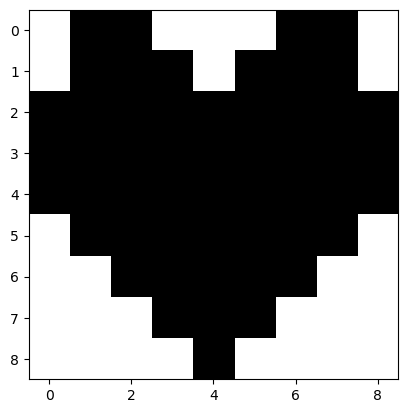

In [3]:
template_img = Image.open("//Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/hearts_work/heart_template.png").convert("L")
template_img = torch.tensor(np.array(template_img),dtype=dtype)/255.0
print(f"Template Image Shape: {template_img.shape}")
plt.imshow(template_img.real,cmap="gray")

template_img = template_img.flatten()

Full Image Shape: torch.Size([32, 32])


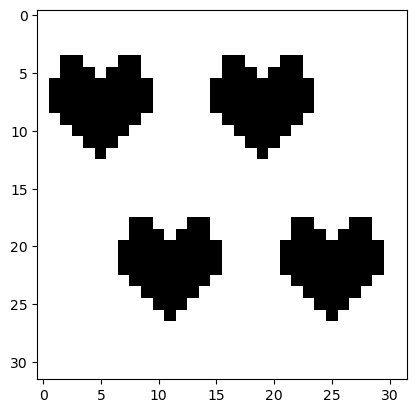

In [4]:
full_img = Image.open("/Users/akashmalemath/Documents/master_work/qcbm_hiwi/qcbm_project/hearts_work/heartss.png").convert("L")
full_img = torch.tensor(np.array(full_img),dtype=dtype)/255.0
print(f"Full Image Shape: {full_img.shape}")

plt.imshow(full_img.real,cmap="gray")

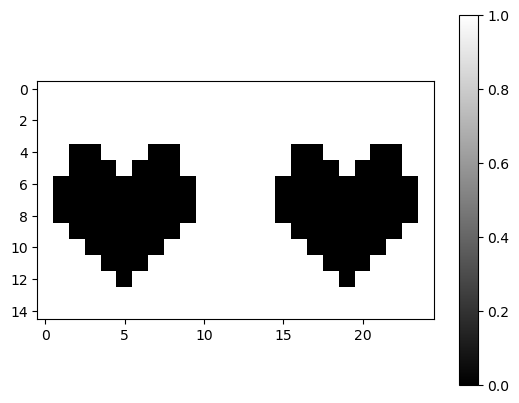

In [5]:
## slice the full_img object to contain 15x25 pixels
full_img = full_img.flatten()
full_img = full_img[:15*32]  # Slicing to get the first 15x32 pixels
full_img = full_img.reshape(15, 32)

## slicing few columns of full_img
full_img = full_img[:, :25]  # Slicing to get the first 25 columns
plt.imshow(full_img.real, cmap='gray')
plt.colorbar()
plt.show()

In [6]:
unfold = torch.nn.Unfold(kernel_size=(9,9), stride=1)
img_patches = unfold(full_img.unsqueeze(0).unsqueeze(0))
img_patches = img_patches.squeeze(0).T

print(f"Number of Image Patches: {img_patches.shape[0]}")
print(f"Single Image Patch Shape: {img_patches.shape[1]}")

Number of Image Patches: 119
Single Image Patch Shape: 81


In [7]:
# a_patch = img_patches[1].reshape(9,9)
# plt.imshow(a_patch, cmap="gray")

In [8]:
### Verifying atleast one patch is similar to the template

def find_similar_patches(img_patches, template_img):
    
    similarity = torch.nn.functional.cosine_similarity(img_patches.real, template_img.unsqueeze(0).real, dim=1)
    
    similar_patches = []
    for i in range(len(similarity)):
        if similarity[i] > 0.99:  # Adjust threshold as needed
            similar_patches.append(i)

    if len(similar_patches) == 0:
        print("No patches are identical to the template.")
    else:
        print(f"Found {len(similar_patches)} patches that are identical to the template at indices: {similar_patches}")
    
    return similar_patches



similar_patches = find_similar_patches(img_patches, template_img)


Found 2 patches that are identical to the template at indices: [69, 83]


## Getting density matrices for the images

In [9]:
n_qubits = math.ceil(math.log2(template_img.shape[0]))
n_ancillas = math.ceil(math.log2(img_patches.shape[0]))
total_qubits = n_qubits + n_ancillas
print("Number of main qubits:", n_qubits)
print("Number of ancilla qubits:", n_ancillas)

Number of main qubits: 7
Number of ancilla qubits: 7


In [10]:
def prepare_padded_data(dataset):

    n = math.ceil(math.log2(dataset.shape[1]))
    padded_data = torch.zeros((dataset.shape[0], 2**n))
    padded_data[:, :dataset.shape[1]] = dataset

    for d in padded_data:
        eps = 1e-6
        
        if torch.linalg.norm(d) < 1e-8:
            d = torch.full_like(d, eps)
        d /= torch.linalg.norm(d)

    return padded_data

In [40]:
psi_template_img = prepare_padded_data(template_img.unsqueeze(0)).squeeze(0)

dm_template_img = torch.einsum("i,j -> ij", psi_template_img, psi_template_img).to(device)
print(f"Density Matrix Template Image Shape: {dm_template_img.shape}")

Density Matrix Template Image Shape: torch.Size([128, 128])


In [41]:
padded_img_patches = prepare_padded_data(img_patches)

def encode_conditional_state_with_ancilla_last(data,total_qubits):

    psi_full = torch.zeros(2**total_qubits, dtype=torch.complex64)

    for i in range(2**n_qubits):
        base_index = i * 128  # because 2^10 = 64 ancilla states

        for j in range(data.shape[0]):
            psi_full[base_index + j] = data[j][i]   

    return psi_full / torch.linalg.norm(psi_full)

psi_img_patches = encode_conditional_state_with_ancilla_last(padded_img_patches, total_qubits)

# dm_img_patches = torch.einsum("i,j -> ij", psi_img_patches, psi_img_patches)
# print(f"Density Matrix Image Patches Shape: {dm_img_patches.shape}")

## Functions

In [50]:
from pennylane.math import reduce_statevector

def sqrtm_torch(matrix:torch.Tensor) -> torch.Tensor:

    eigvals, eigvecs = torch.linalg.eig(matrix)
    eigvals = torch.sqrt(eigvals)
    return eigvecs @ torch.diag(eigvals) @ torch.linalg.inv(eigvecs)


def trdistance_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:

    px = px.cpu()
    py = py.cpu()
    pxy = px - py
    pxy_2 = pxy @ pxy
    dagger_pxy2 = pxy_2.conj().T
    tr_distance = 0.5 * torch.trace(sqrtm_torch(dagger_pxy2 @ pxy_2))
    return tr_distance.real


def qcbm_loss_fn(state:torch.Tensor, py:torch.Tensor, num_qubits=n_qubits):

    state = state.cpu()
    px = reduce_statevector(state, indices=range(num_qubits))
    px = px.to(device, dtype=torch.complex64)
    loss = trdistance_loss(px, py)
    return loss

In [51]:
def qcbm_circuit(state, params, total_qubits):
    rz_params = params[:total_qubits]
    ry_params = params[total_qubits:2*total_qubits]
    rx_params = params[2*total_qubits:3*total_qubits]

    for i in range(total_qubits):
        state = ut.apply_one_site(site=i, state=state, op=QG.Rx(rx_params[i]))
        state = ut.apply_one_site(site=i, state=state, op=QG.Ry(ry_params[i]))
        state = ut.apply_one_site(site=i, state=state, op=QG.Rz(rz_params[i]))
    
    # for i in range(total_qubits - 1):
    #     cnot = QG.CNOT(control=i, target=i+1, n_qubits=total_qubits)
    #     state = cnot @ state
    # cnot = QG.CNOT(control=total_qubits-1, target=0, n_qubits=total_qubits)
    # state = cnot @ state
    for i in range(total_qubits-1):
        state = QG.CNOT(state=state,control=i,target=i+1)
    state = QG.CNOT(state=state,control=total_qubits-1,target=0)

    return state

In [52]:
class QCBM(torch.nn.Module):

    def __init__(self, n_folds=3, n_qubits=n_qubits, n_ancillas=n_ancillas, total_qubits=total_qubits):
        super().__init__()
        self.n_folds = n_folds
        self.n_qubits = n_qubits
        self.n_ancillas = n_ancillas
        self.total_qubits = total_qubits
        self.params = torch.nn.Parameter(torch.randn(n_folds, 3*total_qubits))
        

    def forward(self, x):
        state = x.to(dtype=torch.complex64, device=x.device)
        for i in range(self.n_folds):
            state = qcbm_circuit(state, self.params[i], self.total_qubits)
        
        return state


In [53]:
model = QCBM().to(device=device)
init_state = torch.zeros(2**total_qubits, dtype=torch.complex64, device=device)
init_state[0] = 1.0  # Initialize the state to |0...0>

opt = torch.optim.Adam(model.parameters(), lr=0.1)
n_epochs = 150

loss_history = []
model.train()
i = 0
while i < n_epochs:
    start_time = time.time()
    opt.zero_grad()
    circuit_output = model(init_state).real
    loss = qcbm_loss_fn(circuit_output, dm_template_img)
    loss.backward()
    opt.step()
    end_time = time.time()
    loss_history.append(loss.item())

    i += 1
    if i%1 == 0:
        print(f"Step: {i} Loss: {loss.item()} Time per step: {end_time - start_time:.4f} seconds")


TypeError: Trying to convert ComplexDouble to the MPS backend but it does not have support for that dtype.

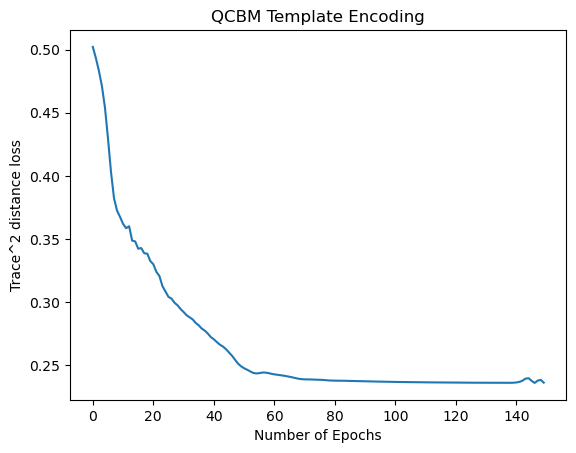

In [18]:
plt.plot(loss_history)
plt.xlabel("Number of Epochs")
plt.ylabel("Trace^2 distance loss")
plt.title("QCBM Template Encoding")
plt.show()

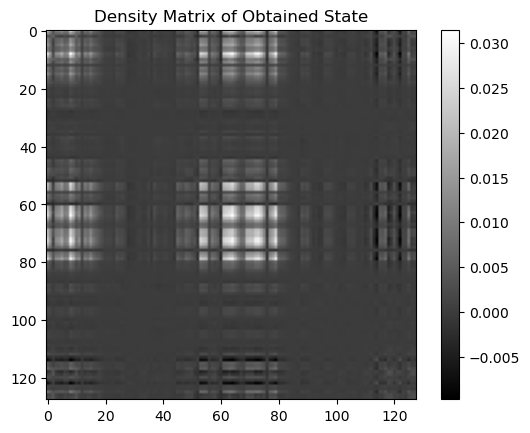

In [41]:
model.eval()
with torch.no_grad():
    final_state = model(init_state).detach().real
    reduced_dm_obtained = reduce_statevector(final_state, indices=range(n_qubits)).real

plt.imshow(reduced_dm_obtained, cmap="gray")
plt.title("Density Matrix of Obtained State")
plt.colorbar()
plt.show()

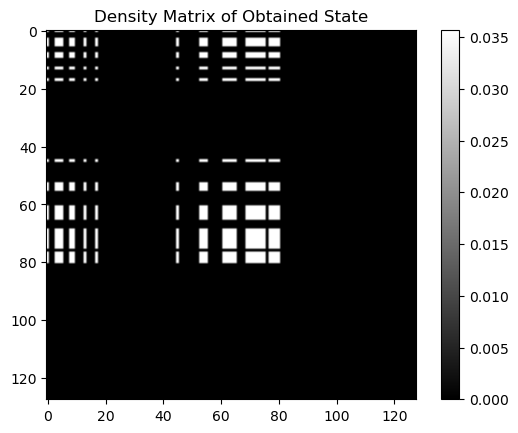

In [42]:
plt.imshow(dm_template_img, cmap="gray")
plt.title("Density Matrix of Obtained State")
plt.colorbar()
plt.show()

## Register Basis Training

In [55]:
def fidelity_loss(px:torch.Tensor, py:torch.Tensor) -> torch.Tensor:
    """
    Computes the fidelity loss between two quantum states.
    """

    fidelity = torch.abs((px.conj().T @ py)**2)

    return -1*fidelity

In [56]:
def reg_circuit(state, params, num_qubits):
    rz_params = params[:num_qubits]
    ry_params = params[num_qubits:2*num_qubits]
    rx_params = params[2*num_qubits:3*num_qubits]

    for i in range(num_qubits):
        state = ut.apply_one_site(site=n_qubits+i, state=state, op=QG.Rx(rx_params[i]))
        state = ut.apply_one_site(site=n_qubits+i, state=state, op=QG.Ry(ry_params[i]))
        state = ut.apply_one_site(site=n_qubits+i, state=state, op=QG.Rz(rz_params[i]))

    for i in range(num_qubits-1):
        state = QG.CNOT(state=state,control=n_qubits+i,target=n_qubits+i+1)
    state = QG.CNOT(state=state,control=num_qubits+n_qubits-1,target=n_qubits)

    return state

In [57]:
class Register(torch.nn.Module):

    def __init__(self, n_folds=3, n_qubits=n_qubits, n_ancillas=n_ancillas, total_qubits=total_qubits):
        super().__init__()
        self.n_folds = n_folds
        self.n_qubits = n_qubits
        self.n_ancillas = n_ancillas
        self.total_qubits = total_qubits
        self.params = torch.nn.Parameter(torch.randn(n_folds, 3*n_qubits))
        

    def forward(self, x):
        state = x.to(dtype=torch.complex64, device=x.device)
        for i in range(self.n_folds):
            state = reg_circuit(state, self.params[i], self.n_qubits)
        
        return state

In [62]:
reg_model = Register()
opt = torch.optim.Adam(reg_model.parameters(), lr=0.01)
n_epochs = 1000

reg_loss_history = []
i = 0

reg_model.train()
while i < n_epochs:
    start_time = time.time()
    opt.zero_grad()
    circuit_output = reg_model(final_state)
    loss = fidelity_loss(circuit_output,psi_img_patches)
    gradient = torch.autograd.grad(loss, reg_model.parameters(), retain_graph=True)
    # print(gradient)
    loss.backward()
    opt.step()
    end_time = time.time()
    reg_loss_history.append(-1*loss.item())

    i += 1
    if i%10 == 0:
        print(f"Step: {i} Loss: {loss.item()} Time per step: {end_time - start_time:.4f} seconds")


Step: 10 Loss: -0.004076271317899227 Time per step: 0.3232 seconds
Step: 20 Loss: -0.007852413691580296 Time per step: 0.3171 seconds
Step: 30 Loss: -0.011209658347070217 Time per step: 0.3058 seconds
Step: 40 Loss: -0.013595940545201302 Time per step: 0.2995 seconds
Step: 50 Loss: -0.015151885338127613 Time per step: 0.3249 seconds
Step: 60 Loss: -0.016508672386407852 Time per step: 0.3153 seconds
Step: 70 Loss: -0.01813388057053089 Time per step: 0.3089 seconds
Step: 80 Loss: -0.02108747884631157 Time per step: 0.3236 seconds
Step: 90 Loss: -0.02802523970603943 Time per step: 0.3115 seconds
Step: 100 Loss: -0.035479605197906494 Time per step: 0.3219 seconds
Step: 110 Loss: -0.03906993195414543 Time per step: 0.3129 seconds
Step: 120 Loss: -0.04010041803121567 Time per step: 0.3106 seconds
Step: 130 Loss: -0.04042081534862518 Time per step: 0.3189 seconds
Step: 140 Loss: -0.04049059376120567 Time per step: 0.2771 seconds
Step: 150 Loss: -0.04051891714334488 Time per step: 0.2777 secon

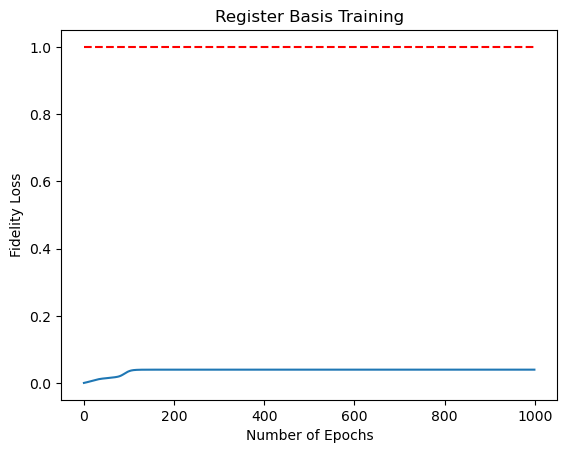

In [63]:
plt.plot(reg_loss_history)
plt.hlines(y=[1.0],xmin=0,xmax=len(reg_loss_history), colors='r', linestyles='dashed', label='Target Fidelity Loss')
plt.xlabel("Number of Epochs")
plt.ylabel("Fidelity Loss")
plt.title("Register Basis Training")
plt.show()

In [64]:
reg_model.eval()
with torch.no_grad():
    reg_final_state = reg_model(final_state).detach().real
    reduced_dm_obtained = reduce_statevector(reg_final_state, indices=range(n_qubits,total_qubits))
    

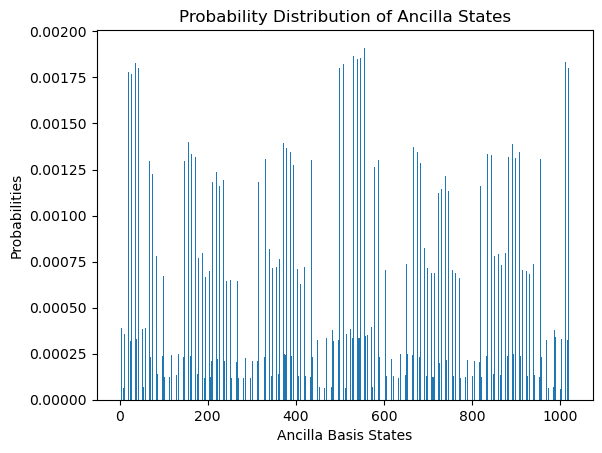

In [66]:
plt.bar(range(2**n_ancillas), torch.diag(reduced_dm_obtained).real)
plt.xlabel("Ancilla Basis States")
plt.ylabel("Probabilities")
plt.title("Probability Distribution of Ancilla States")
plt.show()

In [70]:
max_prob_index = torch.topk(torch.diag(reduced_dm_obtained.real), 4).indices
print(f"Max Probability Index: {max_prob_index}")

Max Probability Index: tensor([ 60, 556, 964, 988])


## Bechmarking CNOT

In [ ]:
def circuit(state):
    
    state = ut.apply_one_site(site=0,state=state,op=QG.X())
    print(state)
    state = QG.CNOT(state=state,control=0,target=1)
    # print(state)

    return state

In [91]:
circuit(torch.tensor([1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=torch.complex64))

tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j])


tensor([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j])